<a href="https://colab.research.google.com/github/sauryanshu55/Food-Identification-ConvNeuralNet/blob/main/Food_Identification_Conv_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c5d9dd53-985b-804f-d6e8-8e45b20708ac)


# Helper Functions

In [3]:
# Source:: Adapted from: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## Using TensdorFlow Datasets (TFDS) to download data

In [5]:
# Load the data
# TFDS: https://www.tensorflow.org/datasets/catalog/food101
import tensorflow_datasets as tfds
(train_data,test_data),ds_info=tfds.load(
    name='food101',
    split=['train','validation'],
    shuffle_files=True,
    as_supervised=True, # data gets returned in tuple type (data, label),
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete2YPTFD/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete2YPTFD/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
# Taking a look at the data
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class names
class_names=ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take a look at training sample
train_one_sample=train_data.take(1);
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [16]:
for image,label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image Datatype: {image.dtype}
  Target class from food 101: {label}
  Class name: {class_names[label.numpy()]}""")


  Image shape: (512, 512, 3)
  Image Datatype: <dtype: 'uint8'>
  Target class from food 101: 23
  Class name: churros


Text(0.5, 1.0, 'churros')

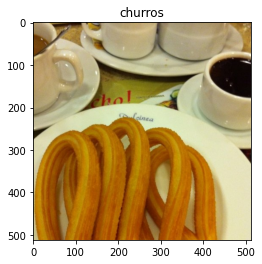

In [18]:
# Plot an image from the dataset
plt.imshow(image)
plt.title(class_names[label.numpy()])
# plt.axis(False)

## Preprocessing the data

In [20]:
# Creation of pre-processing functions for the data
# We need to :
# 1. Reshape the images to the same size (because they are of different shapes)
# 2. Convert dtype fron uint8 to float32 (all tensors are in type uint8)
# No need to scale becuase we will be using EfficientNetBX pre-trained model, whose
# architechture has rescaling built in during training runtime

# data in form of (image, label) tuple
def preprocess_image(image, label, img_shape=224):
  """
  Converts image from dtype uint8 to float32, and reshapes the image to [image_shape, image_shape, color_channel]
  """
  image=tf.image.resize(image,[img_shape,img_shape])
  # image=image/255 Not required for EfficientNetBX
  return tf.cast(image,tf.float32),label # Return tuple obk (image, label)

In [24]:
# Check the output of a preprocessed sample
preprocessed_img=preprocess_image(image,label)[0]
print(f"Before pre-procession: \n {image[:2]}\nShape: {image.shape} \nDataType: {image.dtype}")
print(f"After pre-procession: \n {preprocessed_img[:2]}\nShape: {preprocessed_img.shape} \nDataType: {preprocessed_img.dtype}")

Before pre-procession: 
 [[[189 165 121]
  [185 161 117]
  [181 157 113]
  ...
  [111  72  33]
  [103  64  25]
  [ 94  55  16]]

 [[186 162 118]
  [183 159 115]
  [180 156 112]
  ...
  [122  83  40]
  [113  74  31]
  [105  66  23]]]
Shape: (512, 512, 3) 
DataType: <dtype: 'uint8'>
After pre-procession: 
 [[[184.91327  160.91327  116.91326 ]
  [180.35715  156.35715  112.35714 ]
  [183.71428  160.71428  118.71429 ]
  ...
  [147.5915   108.66289   69.08129 ]
  [123.576454  84.576454  44.198887]
  [106.44359   67.44359   25.872158]]

 [[174.66837  150.66837  106.668365]
  [175.14285  151.14285  107.14286 ]
  [177.80103  153.22958  112.015305]
  ...
  [155.61722  119.545784  68.443695]
  [145.1989   108.19381   53.423363]
  [134.37747   98.30605   40.73462 ]]]
Shape: (224, 224, 3) 
DataType: <dtype: 'float32'>


In [26]:
# Batch datasets
# Map pre-processing function to training dataset
train_data=train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and pre-fetch it 
train_dataa=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Do the same for the test data
# Map pre-processing function to test dataset
test_data=test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle test data and turn it into batches and pre-fetch it 
test_dataa=test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
